In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

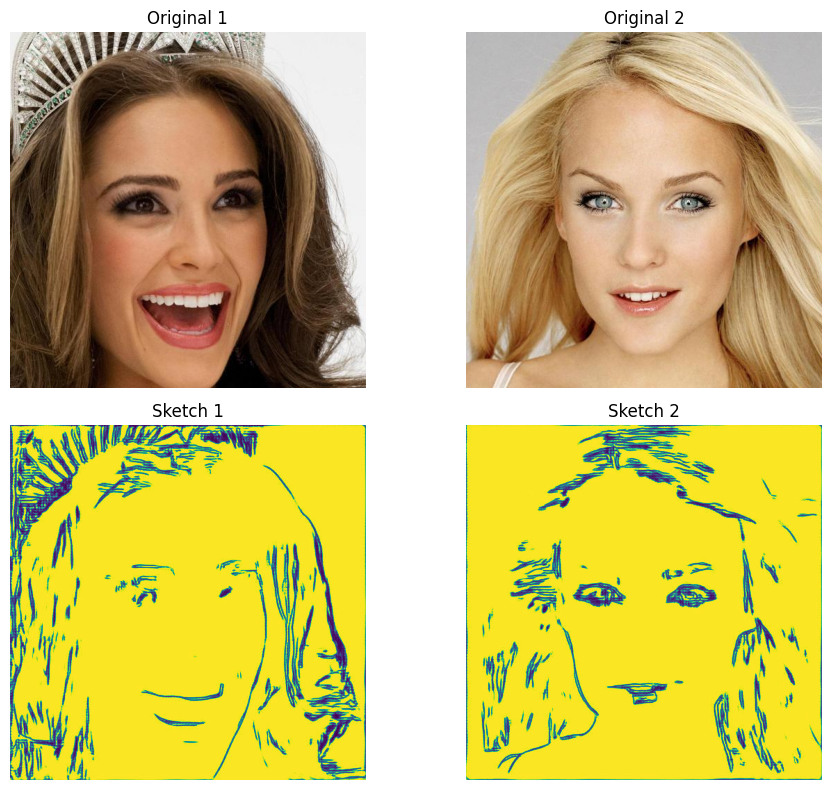

In [7]:
original_images = [

    Image.open('/kaggle/input/person-face-sketches/train/photos/0.jpg'),
    Image.open('/kaggle/input/person-face-sketches/train/photos/1.jpg'),]
sketch_images = [
    Image.open('/kaggle/input/person-face-sketches/train/sketches/0.jpg'),
    Image.open('/kaggle/input/person-face-sketches/train/sketches/1.jpg'),]

# Create a 2x4 grid for the images
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Display original images in the first row
for i, img in enumerate(original_images):
    axes[0, i].imshow(img)
    axes[0, i].axis('off')  # Hide axes
    axes[0, i].set_title(f'Original {i + 1}')  # Optional title for original images

# Display sketch images in the second row
for i, img in enumerate(sketch_images):
    axes[1, i].imshow(img)
    axes[1, i].axis('off')  # Hide axes
    axes[1, i].set_title(f'Sketch {i + 1}')  # Optional title for sketch images

# Display the images
plt.tight_layout()
plt.show()

In [38]:
import torch
import torch.nn as nn


class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)

In [39]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


In [40]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 9):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(img_channels,num_features,kernel_size=7,stride=1,
                      padding=3,padding_mode="reflect",),nn.ReLU(inplace=True),)

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features, 
                    num_features * 2,
                    is_downsampling=True, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))


In [41]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):

        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [42]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels, 
                    feature, 
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output 
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

In [43]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class PersonSketchDataset(Dataset):
    def __init__(self, root_person, root_sketch, transform=None):
        self.root_person = root_person
        self.root_sketch = root_sketch
        self.transform = transform

        self.person_images = os.listdir(root_person)
        self.sketch_images = os.listdir(root_sketch)
        self.length_dataset = max(len(self.person_images), len(self.sketch_images))
        self.zebra_len = len(self.person_images)
        self.horse_len = len(self.sketch_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        person_img = self.person_images[index % self.zebra_len]
        sketch_img = self.sketch_images[index % self.horse_len]

        person_path = os.path.join(self.root_person, person_img)
        sketch_path = os.path.join(self.root_sketch, sketch_img)

        person_img = np.array(Image.open(person_path).convert("RGB"))
        sketch_img = np.array(Image.open(sketch_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=person_img, image0=sketch_img)
            person_img = augmentations["image"]
            sketch_img = augmentations["image0"]

        return person_img, sketch_img


In [44]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

TRAIN_DIR = "/kaggle/input/person-face-sketches/train"
VAL_DIR = "/kaggle/input/person-face-sketches/val"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0 # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 50
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GENERATOR_S = "models/genS.pth.tar"
CHECKPOINT_GENERATOR_P = "models/genP.pth.tar"
CHECKPOINT_DISCRIMINATOR_S = "models/discS.pth.tar"
CHECKPOINT_DISCRIMINATOR_P = "models/discP.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

using device: cuda


In [45]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [46]:
import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

def train_fn(
    disc_S, disc_P, gen_P, gen_S, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    S_reals = 0
    S_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (person, sketch) in enumerate(loop):
        person = person.to(DEVICE)
        sketch = sketch.to(DEVICE)

        # Train discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_sketch = gen_S(person)
            D_S_real = disc_S(sketch)
            D_S_fake = disc_S(fake_sketch.detach())
            S_reals += D_S_real.mean().item()
            S_fakes += D_S_fake.mean().item()
            D_S_real_loss = mse(D_S_real, torch.ones_like(D_S_real))
            D_S_fake_loss = mse(D_S_fake, torch.zeros_like(D_S_fake))
            D_S_loss = D_S_real_loss + D_S_fake_loss

            fake_person = gen_P(sketch)
            D_P_real = disc_P(person)
            D_P_fake = disc_P(fake_person.detach())
            D_P_real_loss = mse(D_P_real, torch.ones_like(D_P_real))
            D_P_fake_loss = mse(D_P_fake, torch.zeros_like(D_P_fake))
            D_P_loss = D_P_real_loss + D_P_fake_loss

            D_loss = (D_S_loss + D_P_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial losses
            D_S_fake = disc_S(fake_sketch)
            D_P_fake = disc_P(fake_person)
            loss_G_S = mse(D_S_fake, torch.ones_like(D_S_fake))
            loss_G_P = mse(D_P_fake, torch.ones_like(D_P_fake))

            # cycle losses
            cycle_person = gen_P(fake_sketch)
            cycle_sketch = gen_S(fake_person)
            cycle_person_loss = l1(person, cycle_person)
            cycle_sketch_loss = l1(sketch, cycle_sketch)

            # identity losses
            # identity_zebra = gen_Z(zebra)
            # identity_horse = gen_H(horse)
            # identity_zebra_loss = l1(zebra, identity_zebra)
            # identity_horse_loss = l1(horse, identity_horse)

            # total loss
            G_loss = (
                loss_G_P
                + loss_G_S
                + cycle_person_loss * LAMBDA_CYCLE
                + cycle_sketch_loss * LAMBDA_CYCLE
                # + identity_horse_loss * LAMBDA_IDENTITY
                # + identity_zebra_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_sketch * 0.5 + 0.5, f"Training_Results/sketch_{idx}.png")
            save_image(fake_person * 0.5 + 0.5, f"Training_Results/person_{idx}.png")

        loop.set_postfix(S_real=S_reals / (idx + 1), S_fake=S_fakes / (idx + 1))


In [ ]:
def main():
    disc_S = Discriminator(in_channels=3).to(DEVICE)
    disc_P = Discriminator(in_channels=3).to(DEVICE)
    gen_P = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_S = Generator(img_channels=3, num_residuals=9).to(DEVICE)

    # use Adam Optimizer for both generator and discriminator
    opt_disc = optim.Adam(
        list(disc_S.parameters()) + list(disc_P.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_P.parameters()) + list(gen_S.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GENERATOR_S,
            gen_S,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GENERATOR_P,
            gen_P,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISCRIMINATOR_S,
            disc_S,
            opt_disc,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISCRIMINATOR_P,
            disc_P,
            opt_disc,
            LEARNING_RATE,
        )

    dataset = PersonSketchDataset(
        root_person=TRAIN_DIR + "/photos",
        root_sketch=TRAIN_DIR + "/sketches",
        transform=transforms,
    )
    val_dataset = PersonSketchDataset(
        root_person=VAL_DIR + "/photos",
        root_sketch=VAL_DIR + "/sketches",
        transform=transforms,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_S,
            disc_P,
            gen_P,
            gen_S,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_S, opt_gen, filename=CHECKPOINT_GENERATOR_S)
            save_checkpoint(gen_P, opt_gen, filename=CHECKPOINT_GENERATOR_P)
            save_checkpoint(disc_S, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_S)
            save_checkpoint(disc_P, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_P)


main()

100%|██████████| 20655/20655 [55:57<00:00,  6.15it/s, S_fake=0.234, S_real=0.761]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 20655/20655 [55:48<00:00,  6.17it/s, S_fake=0.172, S_real=0.825]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 20655/20655 [55:48<00:00,  6.17it/s, S_fake=0.135, S_real=0.86] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 20655/20655 [56:00<00:00,  6.15it/s, S_fake=0.0914, S_real=0.891]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 20655/20655 [55:56<00:00,  6.15it/s, S_fake=0.0963, S_real=0.899]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 20655/20655 [55:46<00:00,  6.17it/s, S_fake=0.0843, S_real=0.911]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 20655/20655 [55:48<00:00,  6.17it/s, S_fake=0.0785, S_real=0.905]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


 96%|█████████▌| 19759/20655 [53:22<02:24,  6.19it/s, S_fake=0.0794, S_real=0.907]